# Face Mask Object Detection.

## Install, Imports and Setup

Installing Dependencies and getting necessary scripts

In [ ]:
# Cloing torchvision repo and copying helper files
!git clone https://github.com/pytorch/vision.git
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/coco_utils.py ./
!cp vision/references/detection/engine.py ./

In [1]:
# Installing dependencies
!pip install -q opendatasets
!pip install -q albumentations
!pip install -q pycocotools
!pip install -q torchinfo

Importing libraries

In [2]:
import os
import random
import opendatasets as od
from pathlib import Path
import numpy as np
import pandas as pd

# XML library 
from xml.etree import ElementTree

import warnings
warnings.filterwarnings('ignore')

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from engine import train_one_epoch, evaluate
import utils
import transforms as T

import torch
import torchvision
from torchvision.utils import draw_bounding_boxes
from torchvision import transforms
from torchvision.transforms import ToPILImage
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchinfo import summary

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

## Dataset

In [3]:
# Creating a data folder
data_dir = Path('data')
if data_dir.exists():
    print('[INFO] Data directory already exist.\n[INFO] Skipping data download.')
else:
    print('[INFO] Creating a data directory.')
    data_dir.mkdir(parents=True,
                   exist_ok=True)
    # Downloading dataset from kaggle
    od.download_kaggle_dataset(dataset_url='https://www.kaggle.com/datasets/andrewmvd/face-mask-detection?select=images',
                               data_dir=data_dir)

[INFO] Data directory already exist.
[INFO] Skipping data download.


In [3]:
# Defining the data directories
image_dir = Path('data/face-mask-detection/images')
annot_dir = Path('data/face-mask-detection/annotations')

In [5]:
# Confirming the file types in the dataset
images_ext = [x for x in os.listdir(image_dir)]
annot_ext = [x for x in os.listdir(annot_dir)]
unique = []
for i in images_ext:
    i = i[-4:]
    if i not in unique:
        unique.append(i)
for i in annot_ext:
    i = i[-4:]
    if i not in unique:
        unique.append(i)
unique

['.png', '.xml']

In [4]:
# Creating a class to generate dataset
class MaskDetection(torch.utils.data.Dataset):
    """
    A class to create a dataset using the image and annotation data,
    Transforms the image and returns a tuple with the image and target data.
    Args:
        image_dir: A directory path for the images data.
        annot_dir: A directory path for the annotation data.
        width: An integer to resize the width of the image.
        height: An integer to resize the height of the image.
        transforms(default: None): A torchvision or albumentations transform to apply multiple image transformation.
    Returns:
        img_res: Transformed image data.
        target: A dictionary containing bounding boxes, labels, area, iscrowd, image_id.
    """
    def __init__(self, image_dir, annot_dir, width, height, transforms=None):
        self.image_dir = image_dir
        self.annot_dir = annot_dir
        self.width = width
        self.height = height
        self.transforms = transforms

        # List of images and annots
        self.images = [image for image in sorted(os.listdir(self.image_dir))]
        self.annots = [annot for annot in sorted(os.listdir(self.annot_dir))]

        # List of classes - 0 index for background as a default
        self.classes = [_, 'with_mask', 'without_mask', 'mask_weared_incorrect']
    
    def __getitem__(self, index):
        image_name = self.images[index]
        image_path = os.path.join(self.image_dir, image_name)

        # Reading the images and converting them to correct size and color
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        img_res /= 255.0 # Normalizing the image

        # Creating annotation files
        annot_name = self.annots[index]
        annot_path = os.path.join(self.annot_dir, annot_name)

        # Getting the height and width of the image
        ht = img.shape[0]
        wt = img.shape[1]

        # Collecting class and bounding box details from the annotation files
        boxes = []
        labels = []
        tree = ElementTree.parse(annot_path)
        root = tree.getroot()
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            # Finding the bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            # calculating the co-ordinates
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            if xmin_corr > float(self.width):
                xmin_corr = float(self.width)
            if xmax_corr > float(self.width):
                xmax_corr = float(self.width)
            if ymin_corr > float(self.height):
                ymin_corr = float(self.height)
            if ymax_corr > float(self.height):
                ymax_corr = float(self.height)
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # Convert the boxes and labels to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32 )
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Getting the area of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # If all the instance are not crowded
        iscrowd = torch.zeros((boxes.shape[0]), dtype=torch.int64)

        # Creating image index
        image_id = torch.tensor([index])

        # Creating target dictionary
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['area'] = area
        target['iscrowd'] = iscrowd
        target['image_id'] = image_id

        # Setting transform and returning image and target data
        if self.transforms:
            sample = self.transforms(image=img_res,
                                     bboxes=target['boxes'],
                                     labels=labels)
            img_res = sample['image']
            target['boxes'] = torch.tensor(sample['bboxes'])
        return img_res, target
    
    def __len__(self):
        return len(self.images)

In [7]:
# Check dataset
dataset = MaskDetection(image_dir=image_dir, annot_dir=annot_dir, width=224, height=224)
print('Length of dataset: ', len(dataset), '\n')

# Getting the image and target for a test index. Feel free to change the index.
img, target = dataset[0]
print('Image shape:', img.shape)
print('Target details:', target)

Length of dataset:  853 

Image shape: (224, 224, 3)
Target details: {'boxes': tensor([[ 34.5625,  64.2623,  47.6875,  86.9071],
        [ 80.9375,  61.2022,  98.8750,  88.1311],
        [142.1875,  55.0820, 157.5000,  86.2951]]), 'labels': tensor([2, 1, 2]), 'area': tensor([297.2131, 483.0383, 477.9508]), 'iscrowd': tensor([0, 0, 0]), 'image_id': tensor([0])}


# Visualization

In [5]:
# Creating a function to visualize the data from the above dataset.
def plot_image(image):
    """
    A function to display single image.
    Args:
        image: A numerical array or tensor of an image in a shape compatible with Matplotlib.
               Image can be read by any method for e.g. plt.imread() or cv2.imread().
    """
    plt.imshow(image)
    plt.axis(False)

def plot_grid(dataset, rows=5, cols=5):
    """
    A function to display a grid of images.
    Args:
        dataset: A dataset with images and target data.
        rows(defaut=5): Number of rows for the grid.
        cols(default=5): Nuber of columns for the grid.
    """
    fig = plt.figure(figsize=(25, 25))
    total_imgs = rows * cols
    for i in range(total_imgs):
        imgs, target = dataset[i]
        fig.add_subplot(rows, cols, i+1)
        plot_image(image=imgs)
    plt.show()

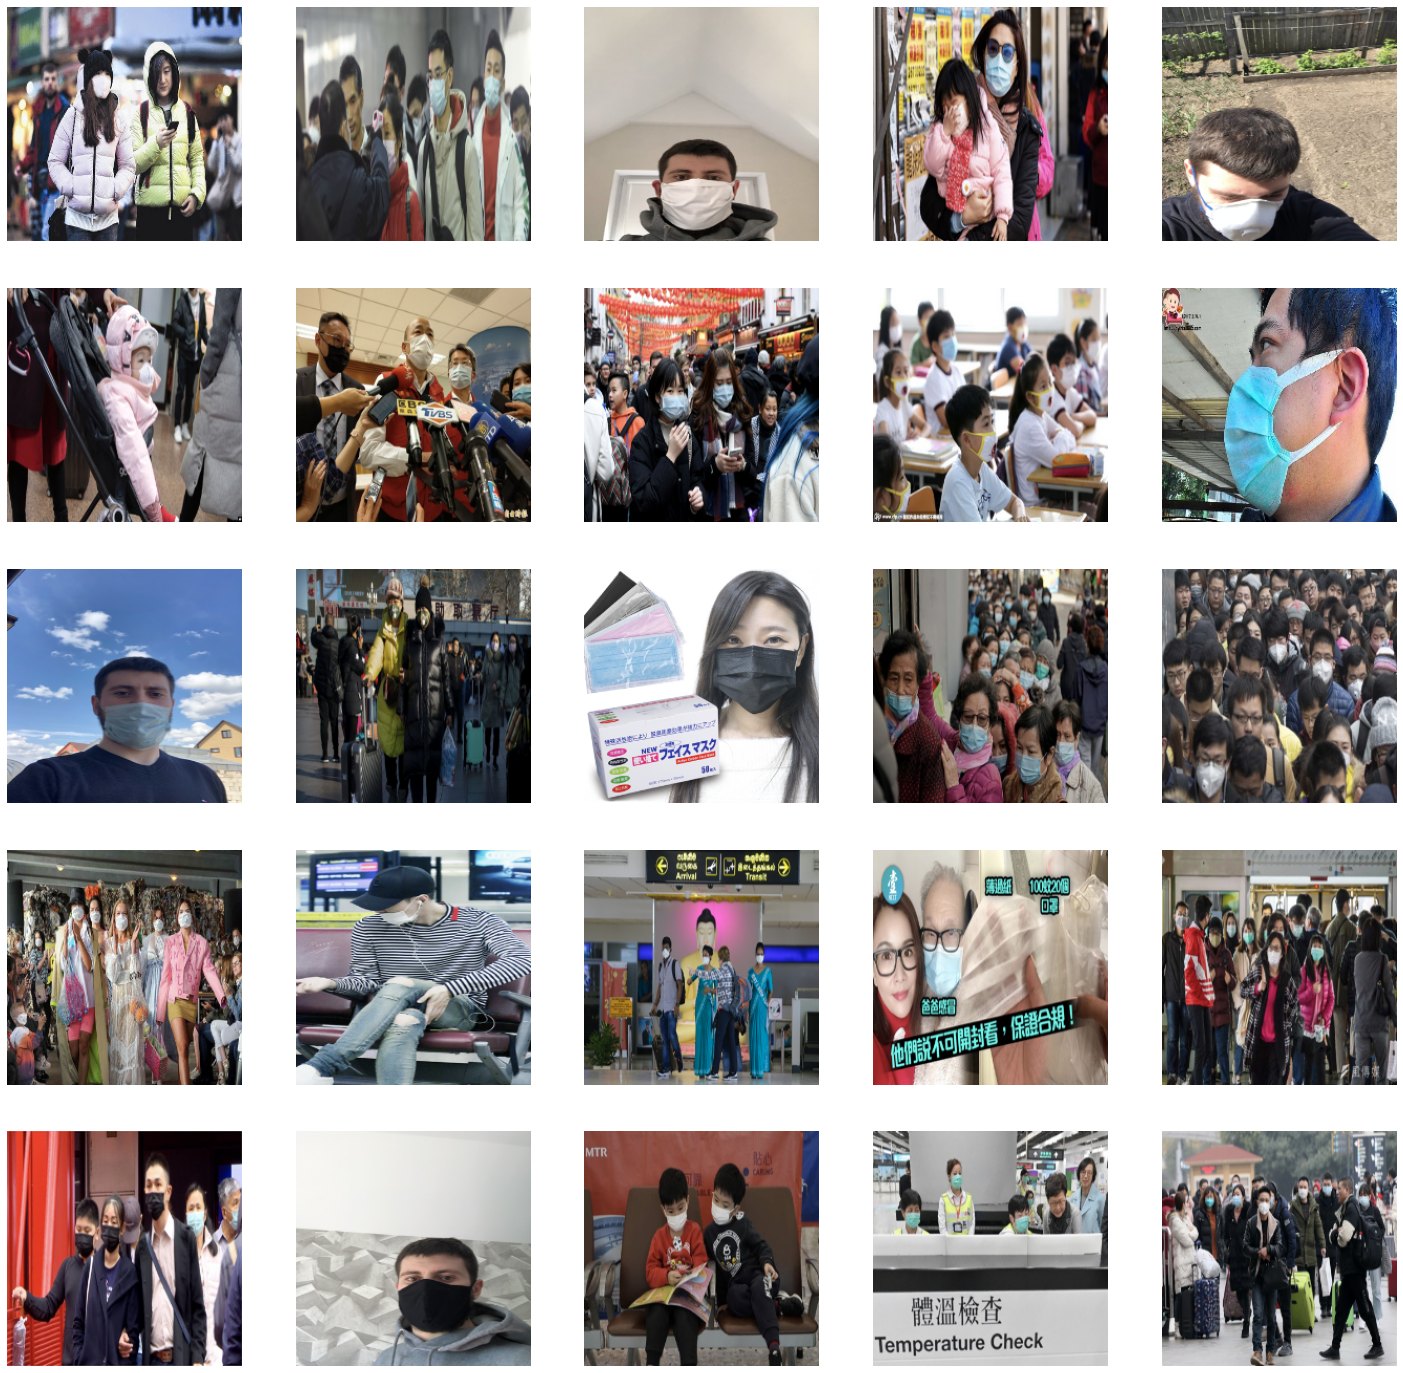

In [9]:
# Visualizing different images in a grid(without bounding box)
plot_grid(dataset=dataset)

In [6]:
def class_to_color(class_id):
    """
    A function to suggest color for the bounding box as per the classes.
    Args:
        class_id: A int for selecting a color from a list.
    Returns:
        A tuple with three values for RGB in a format of 0 and 1.
    """
    colors = [(0, 0, 0), (0, 255, 0), (255, 0, 0), (0, 0, 255)]
    return colors[class_id]

def draw_bounding_box(image, target, transform: bool):
    """
    A function to create bounding box with specific color as per the class.
    Args:
        image: A numerical array or tensor of an image in a shape compatible with Matplotlib.
               Image can be read by any method for e.g. plt.imread() or cv2.imread().
        target: A python dictionary containing data for the box and labels.
                Box data needs to have a key name as 'bboxes' and label data as 'labels' within the target dict.
                Box and labels data should be a list. 
                Box format should be a pascal voc format and labels should be a int for each classes.
        transform: A boolean to indicate that Albumentations transform is been applied or not.
    """
    if transform == True:
        box = target['bboxes']
    else:
        box = target['boxes']
    image = torch.tensor(image*255., dtype=torch.uint8)
    if image.shape[0] != 3:
        image = image.permute(2, 0, 1)
    box = torch.tensor(box, dtype=torch.int)
    class_colors = []
    for i in target['labels']:
        class_colors.append(class_to_color(i))
    image = draw_bounding_boxes(image, box, width=2, colors=class_colors)
    image = ToPILImage()(image)
    return image

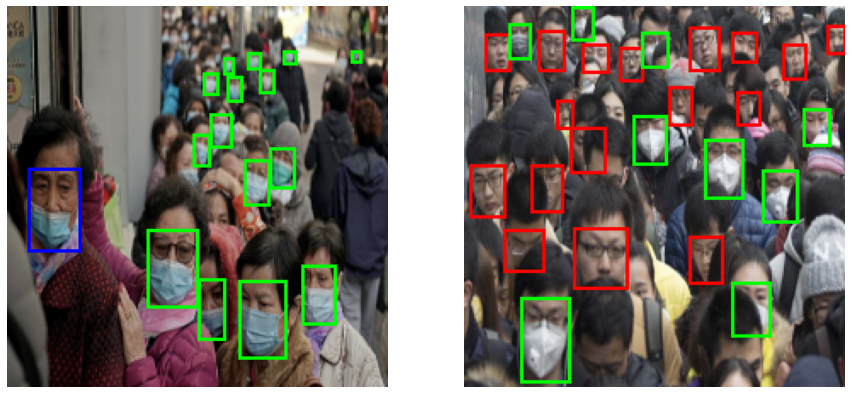

In [9]:
# Visualizing a image with bounding box.
# Bounding box color represent different classes{Green: 'with_mask', Red: 'without_mask', Blue: 'mask_weared_incorrect'} 
fig = plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
img, target = dataset[13]
plot_image(draw_bounding_box(img, target, transform=False))
plt.subplot(1, 2, 2)
img, target = dataset[14]
plot_image(draw_bounding_box(img, target, transform=False));

In [7]:
def plot_bbox_grid(dataset, transform: bool, rows=5, cols=5):
    """
    A function to display a grid of images with their bounding box.
    Args:
        dataset: A dataset with images and target data.
        rows(defaut=5): Number of rows for the grid.
        cols(default=5): Nuber of columns for the grid.
    """
    fig = plt.figure(figsize=(25, 25))
    total_imgs = rows * cols
    for i in range(total_imgs):
        img, target = dataset[i]
        fig.add_subplot(rows, cols, i+1)
        plot_image(draw_bounding_box(img, target, transform))
    plt.show()

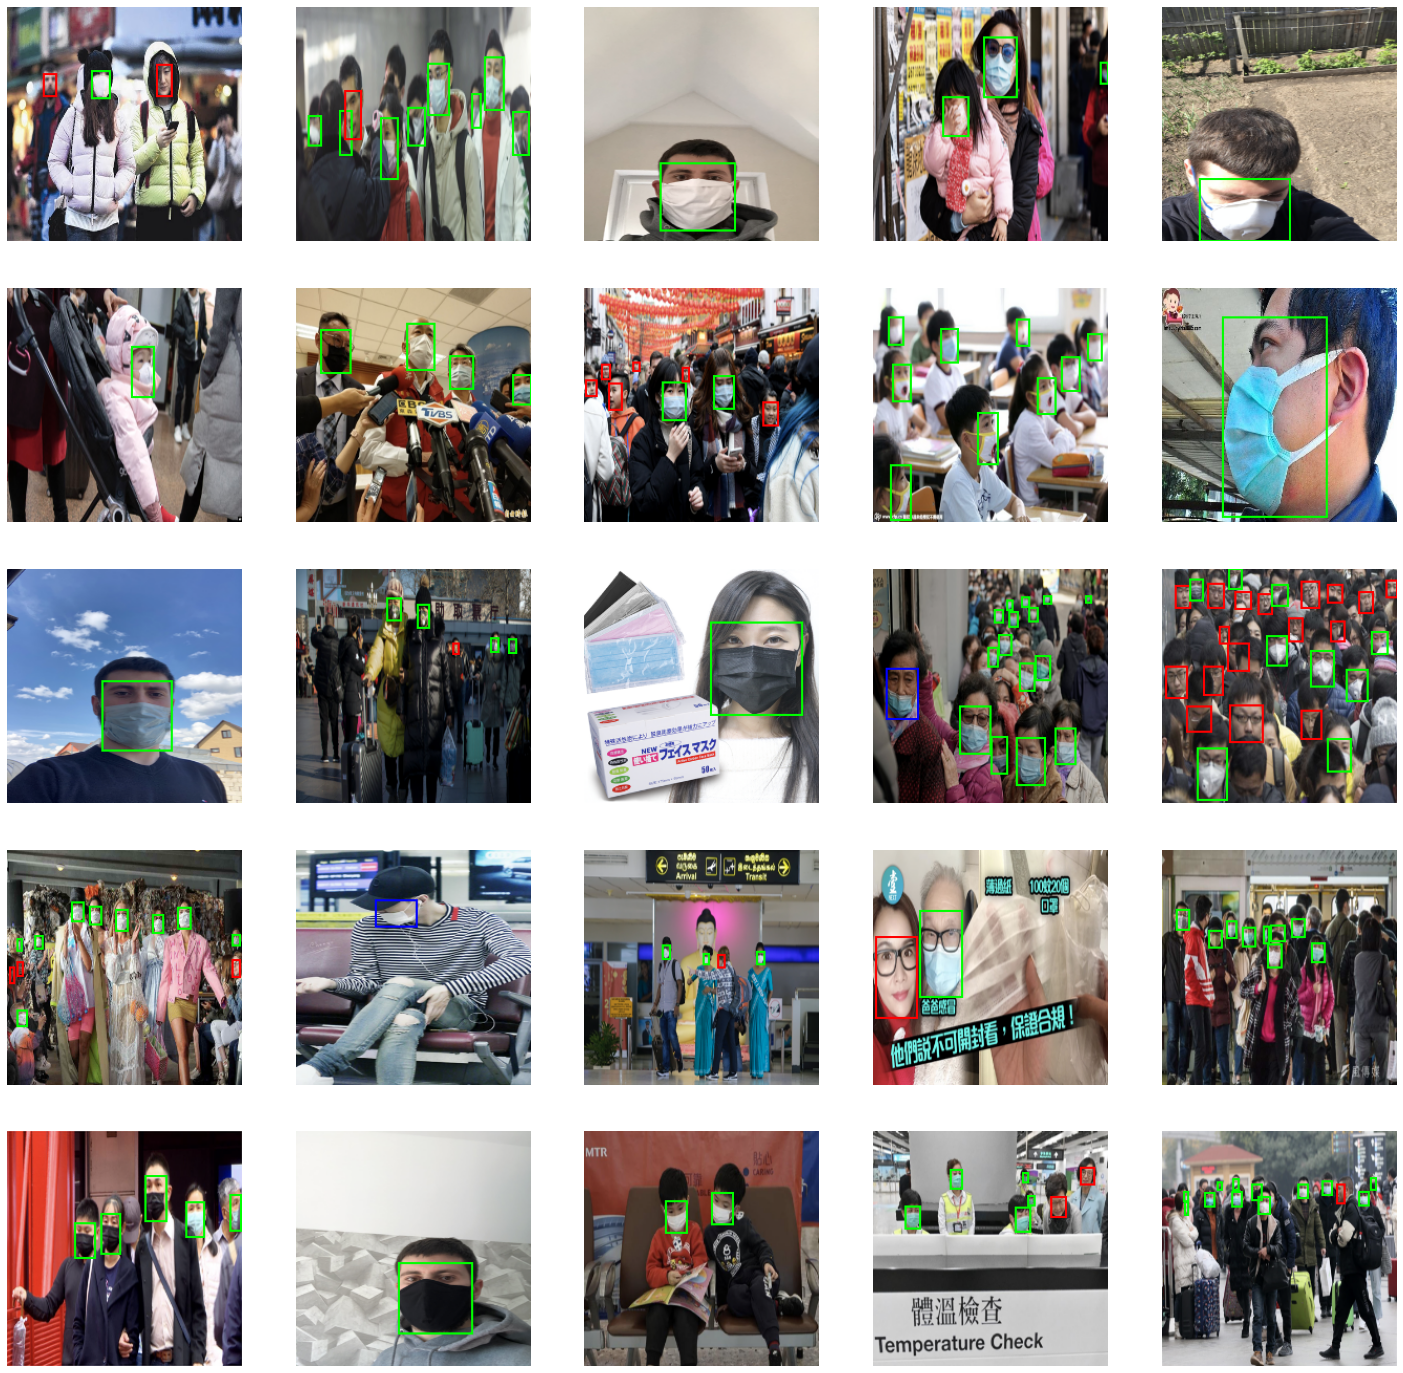

In [13]:
# Visualizing different images in a grid(with bounding box)
plot_bbox_grid(dataset=dataset, transform=False)

# Augmentation

This is where we can apply augmentations to the image.

The augmentations to object detection vary from normal augmentations becuase here we need to ensure that, bbox still aligns with the object correctly after transforming. Here I have added random flip transform

In [8]:
# Seprating the transform for train and val dataset
def get_transform(train: bool):
    """
    A function to create image augmentation using the Aulbumentations package.
    Args:
        train: A boolean input for justifying the augmentation on a training or validation dataset.
    return:
        A python dictionary containg 'image': In pytorch tensor format, 
                                     'bboxes': In pascal voc format.
                                     'labels': A int for class representation.
    """
    if train:
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    else:
        return A.Compose([
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

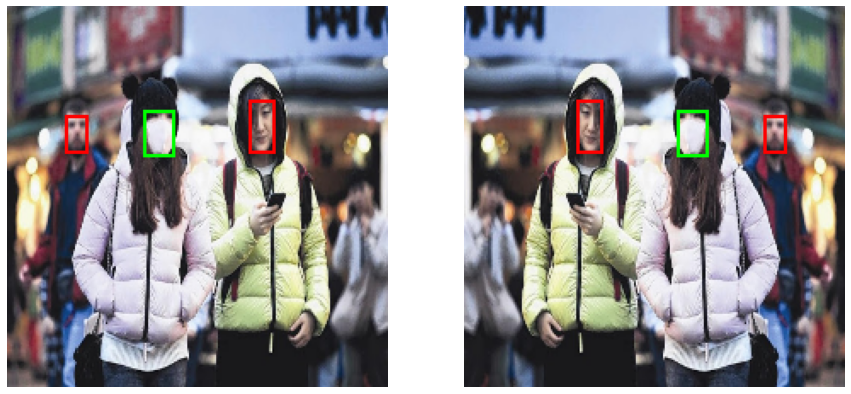

In [18]:
# Applying image augmentation to a single image - comparison
img, target = dataset[0]
plt.figure(figsize=(15, 7))

# Image before augmentation
plt.subplot(1, 2, 1)
plot_image(draw_bounding_box(image=img, target=target, transform=False))

# Image after augmentation
plt.subplot(1, 2, 2)
temp_transform = get_transform(train=True)
dataset_trans = temp_transform(image=img, bboxes=target['boxes'], labels=target['labels'])
img = dataset_trans['image'].cpu().detach().numpy()
plot_image(draw_bounding_box(image=img, target=dataset_trans, transform=True));

# Dataloaders

Make a loader for feeding our data into the neural network

Now lets prepare the datasets and dataloaders for training and testing.

In [9]:
# using our dataset to create train and test split
# Train dataset with augmentation and test dataset without augmentation
train_dataset = MaskDetection(image_dir=image_dir,
                              annot_dir=annot_dir,
                              width=224,
                              height=224,
                              transforms=get_transform(train=True))
test_dataset = MaskDetection(image_dir=image_dir,
                             annot_dir=annot_dir,
                             width=224,
                             height=224,
                             transforms=get_transform(train=False))
print(len(train_dataset), len(test_dataset))

853 853


In [10]:
# Creating a list of random permutation of indices
torch.manual_seed(42)
indices = torch.randperm(len(train_dataset)).tolist()
indices[:10]

[668, 156, 807, 117, 580, 428, 207, 21, 663, 306]

In [11]:
# Creating PyTorch dataset for traing and testing.
test_split = 0.2
test_size = int(len(train_dataset) * test_split)
train_dataset = torch.utils.data.Subset(dataset=train_dataset,
                                        indices=indices[:-test_size])
test_dataset = torch.utils.data.Subset(dataset=test_dataset,
                                       indices=indices[-test_size:])
print(f'[INFO] Size of the training dataset: {len(train_dataset)} and size of the testing dataset: {len(test_dataset)}')

[INFO] Size of the training dataset: 683 and size of the testing dataset: 170


In [12]:
# Defining the training and testing DataLoaders using the PyTorch dataset.
BATCH_SIZE = 10
NUM_WORKERS = os.cpu_count()
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=NUM_WORKERS,
                                               collate_fn=utils.collate_fn,
                                               pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=NUM_WORKERS,
                                              collate_fn=utils.collate_fn,
                                              pin_memory=True)

In [14]:
next(iter(test_dataloader))

[[tensor([[[0.3029, 0.3221, 0.3760,  ..., 0.4388, 0.4311, 0.4351],
           [0.3145, 0.3418, 0.3886,  ..., 0.4402, 0.4366, 0.4342],
           [0.3287, 0.3695, 0.4202,  ..., 0.4450, 0.4399, 0.4360],
           ...,
           [0.0164, 0.4094, 0.3904,  ..., 0.0988, 0.0732, 0.0622],
           [0.0730, 0.1468, 0.3235,  ..., 0.1158, 0.1095, 0.0881],
           [0.1555, 0.1278, 0.0994,  ..., 0.1437, 0.1439, 0.1337]],
  
          [[0.3015, 0.3217, 0.3680,  ..., 0.4388, 0.4311, 0.4351],
           [0.3134, 0.3436, 0.3772,  ..., 0.4402, 0.4366, 0.4342],
           [0.3247, 0.3695, 0.4088,  ..., 0.4450, 0.4399, 0.4360],
           ...,
           [0.0130, 0.4076, 0.3902,  ..., 0.1009, 0.0788, 0.0661],
           [0.0460, 0.1267, 0.3193,  ..., 0.1170, 0.1143, 0.0920],
           [0.1281, 0.0996, 0.0427,  ..., 0.1473, 0.1478, 0.1412]],
  
          [[0.2785, 0.3014, 0.3372,  ..., 0.4429, 0.4360, 0.4382],
           [0.2915, 0.3233, 0.3488,  ..., 0.4442, 0.4438, 0.4368],
           [0.3079, 0.

# Experiment No. 1

## Model Creation

In [13]:
# Creating a function that builds a model
def get_fasterrcnn_resnet50_model(num_classes):
    # Load weights and model of a pre-trained model
    weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=weights)

    # Get the input parameters of the classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head num_classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features,
                                                      num_classes=num_classes)
    return model  

## Model Training

In [14]:
# Setting up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [17]:
# Creating the model using the helper function
# 0 is background, 1 is 'with_mask', 2 is 'without_mask' and 3 is 'mask_weared_incorrect'
NUM_CLASSES = 4 
model_1 = get_fasterrcnn_resnet50_model(num_classes=NUM_CLASSES)
model_1.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth


  0%|          | 0.00/167M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [27]:
# Constructing optimizer
params = [p for p in model_1.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params=params,
                            lr=0.005,
                            momentum=0.9,
                            weight_decay=0.0005)

# Constructing Learning Rate Scheduler for 10x on every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [28]:
# Training the model for 5 epochs
NUM_EPOCHS = 5

for epoch in range(NUM_EPOCHS):
    # Training for one epoch
    train_one_epoch(model=model_1,
                    optimizer=optimizer,
                    data_loader=train_dataloader,
                    device=device,
                    epoch=epoch,
                    print_freq=10)
    
    # Update the learning rate
    lr_scheduler.step()

    # Evaluate on the test dataset
    evaluate(model=model_1,
             data_loader=test_dataloader,
             device=device)

Epoch: [0]  [ 0/69]  eta: 0:05:17  lr: 0.000078  loss: 1.7514 (1.7514)  loss_classifier: 1.4756 (1.4756)  loss_box_reg: 0.1609 (0.1609)  loss_objectness: 0.1001 (0.1001)  loss_rpn_box_reg: 0.0148 (0.0148)  time: 4.6080  data: 0.5640  max mem: 11845
Epoch: [0]  [10/69]  eta: 0:01:18  lr: 0.000813  loss: 1.5555 (1.4755)  loss_classifier: 1.2577 (1.1130)  loss_box_reg: 0.1578 (0.1591)  loss_objectness: 0.1361 (0.1669)  loss_rpn_box_reg: 0.0356 (0.0365)  time: 1.3370  data: 0.0515  max mem: 12132
Epoch: [0]  [20/69]  eta: 0:00:58  lr: 0.001548  loss: 0.8345 (1.1031)  loss_classifier: 0.4294 (0.7441)  loss_box_reg: 0.1751 (0.1845)  loss_objectness: 0.1069 (0.1379)  loss_rpn_box_reg: 0.0315 (0.0366)  time: 1.0135  data: 0.0004  max mem: 12132
Epoch: [0]  [30/69]  eta: 0:00:44  lr: 0.002282  loss: 0.7388 (1.0141)  loss_classifier: 0.3681 (0.6394)  loss_box_reg: 0.2430 (0.2276)  loss_objectness: 0.0741 (0.1138)  loss_rpn_box_reg: 0.0270 (0.0333)  time: 1.0232  data: 0.0004  max mem: 12132


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


Epoch: [0]  [40/69]  eta: 0:00:32  lr: 0.003017  loss: 0.7197 (0.9205)  loss_classifier: 0.3465 (0.5398)  loss_box_reg: 0.3201 (0.2517)  loss_objectness: 0.0579 (0.1003)  loss_rpn_box_reg: 0.0161 (0.0287)  time: 1.0368  data: 0.0004  max mem: 12132
Epoch: [0]  [50/69]  eta: 0:00:20  lr: 0.003751  loss: 0.5343 (0.8492)  loss_classifier: 0.1882 (0.4715)  loss_box_reg: 0.2986 (0.2614)  loss_objectness: 0.0477 (0.0893)  loss_rpn_box_reg: 0.0139 (0.0271)  time: 1.0584  data: 0.0004  max mem: 12132
Epoch: [0]  [60/69]  eta: 0:00:09  lr: 0.004486  loss: 0.5207 (0.7957)  loss_classifier: 0.1666 (0.4229)  loss_box_reg: 0.2734 (0.2654)  loss_objectness: 0.0319 (0.0816)  loss_rpn_box_reg: 0.0142 (0.0257)  time: 1.0922  data: 0.0003  max mem: 12132
Epoch: [0]  [68/69]  eta: 0:00:01  lr: 0.005000  loss: 0.4659 (0.7450)  loss_classifier: 0.1421 (0.3868)  loss_box_reg: 0.2603 (0.2567)  loss_objectness: 0.0311 (0.0756)  loss_rpn_box_reg: 0.0156 (0.0258)  time: 1.0637  data: 0.0002  max mem: 12132
Epoc

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


creating index...
index created!
Test:  [ 0/17]  eta: 0:00:21  model_time: 0.4711 (0.4711)  evaluator_time: 0.0227 (0.0227)  time: 1.2471  data: 0.7522  max mem: 12132
Test:  [16/17]  eta: 0:00:00  model_time: 0.4470 (0.4488)  evaluator_time: 0.0217 (0.0356)  time: 0.5296  data: 0.0444  max mem: 12132
Test: Total time: 0:00:09 (0.5365 s / it)
Averaged stats: model_time: 0.4470 (0.4488)  evaluator_time: 0.0217 (0.0356)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.222
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.429
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.208
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.413
 Average Recall     (AR) @[ Io

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


Epoch: [1]  [20/69]  eta: 0:00:52  lr: 0.005000  loss: 0.3883 (0.3794)  loss_classifier: 0.1271 (0.1305)  loss_box_reg: 0.2258 (0.2151)  loss_objectness: 0.0134 (0.0181)  loss_rpn_box_reg: 0.0104 (0.0156)  time: 1.0458  data: 0.0002  max mem: 12132
Epoch: [1]  [30/69]  eta: 0:00:41  lr: 0.005000  loss: 0.3670 (0.3828)  loss_classifier: 0.1262 (0.1328)  loss_box_reg: 0.2198 (0.2166)  loss_objectness: 0.0134 (0.0182)  loss_rpn_box_reg: 0.0105 (0.0152)  time: 1.0513  data: 0.0002  max mem: 12132
Epoch: [1]  [40/69]  eta: 0:00:31  lr: 0.005000  loss: 0.3238 (0.3657)  loss_classifier: 0.1085 (0.1272)  loss_box_reg: 0.1918 (0.2080)  loss_objectness: 0.0125 (0.0168)  loss_rpn_box_reg: 0.0099 (0.0137)  time: 1.0647  data: 0.0003  max mem: 12132
Epoch: [1]  [50/69]  eta: 0:00:20  lr: 0.005000  loss: 0.3058 (0.3612)  loss_classifier: 0.1021 (0.1236)  loss_box_reg: 0.1766 (0.2062)  loss_objectness: 0.0123 (0.0172)  loss_rpn_box_reg: 0.0069 (0.0142)  time: 1.0830  data: 0.0004  max mem: 12132
Epoc

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


creating index...
index created!
Test:  [ 0/17]  eta: 0:00:23  model_time: 0.4776 (0.4776)  evaluator_time: 0.0130 (0.0130)  time: 1.3954  data: 0.9032  max mem: 12132
Test:  [16/17]  eta: 0:00:00  model_time: 0.4458 (0.4484)  evaluator_time: 0.0148 (0.0167)  time: 0.5190  data: 0.0532  max mem: 12132
Test: Total time: 0:00:08 (0.5256 s / it)
Averaged stats: model_time: 0.4458 (0.4484)  evaluator_time: 0.0148 (0.0167)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.614
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.368
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.448
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.610
 Average Recall     (AR) @[ Io

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


Epoch: [2]  [60/69]  eta: 0:00:09  lr: 0.005000  loss: 0.2324 (0.2804)  loss_classifier: 0.0689 (0.0924)  loss_box_reg: 0.1444 (0.1667)  loss_objectness: 0.0060 (0.0099)  loss_rpn_box_reg: 0.0047 (0.0113)  time: 1.0804  data: 0.0002  max mem: 12132
Epoch: [2]  [68/69]  eta: 0:00:01  lr: 0.005000  loss: 0.2070 (0.2768)  loss_classifier: 0.0656 (0.0911)  loss_box_reg: 0.1434 (0.1654)  loss_objectness: 0.0060 (0.0096)  loss_rpn_box_reg: 0.0044 (0.0107)  time: 1.0375  data: 0.0002  max mem: 12132
Epoch: [2] Total time: 0:01:13 (1.0664 s / it)


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


creating index...
index created!
Test:  [ 0/17]  eta: 0:00:19  model_time: 0.5011 (0.5011)  evaluator_time: 0.0126 (0.0126)  time: 1.1540  data: 0.6392  max mem: 12132
Test:  [16/17]  eta: 0:00:00  model_time: 0.4465 (0.4495)  evaluator_time: 0.0108 (0.0117)  time: 0.4996  data: 0.0378  max mem: 12132
Test: Total time: 0:00:08 (0.5077 s / it)
Averaged stats: model_time: 0.4465 (0.4495)  evaluator_time: 0.0108 (0.0117)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.425
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.717
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.474
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.564
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.635
 Average Recall     (AR) @[ Io

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


Epoch: [3]  [30/69]  eta: 0:00:41  lr: 0.000500  loss: 0.2355 (0.2583)  loss_classifier: 0.0744 (0.0851)  loss_box_reg: 0.1441 (0.1538)  loss_objectness: 0.0059 (0.0089)  loss_rpn_box_reg: 0.0070 (0.0105)  time: 1.0546  data: 0.0003  max mem: 12132
Epoch: [3]  [40/69]  eta: 0:00:31  lr: 0.000500  loss: 0.2191 (0.2525)  loss_classifier: 0.0729 (0.0835)  loss_box_reg: 0.1384 (0.1505)  loss_objectness: 0.0044 (0.0087)  loss_rpn_box_reg: 0.0064 (0.0098)  time: 1.0709  data: 0.0003  max mem: 12132
Epoch: [3]  [50/69]  eta: 0:00:20  lr: 0.000500  loss: 0.2199 (0.2493)  loss_classifier: 0.0789 (0.0820)  loss_box_reg: 0.1384 (0.1487)  loss_objectness: 0.0048 (0.0089)  loss_rpn_box_reg: 0.0071 (0.0097)  time: 1.0901  data: 0.0003  max mem: 12132
Epoch: [3]  [60/69]  eta: 0:00:09  lr: 0.000500  loss: 0.2366 (0.2483)  loss_classifier: 0.0733 (0.0811)  loss_box_reg: 0.1454 (0.1486)  loss_objectness: 0.0067 (0.0088)  loss_rpn_box_reg: 0.0076 (0.0098)  time: 1.0935  data: 0.0003  max mem: 12132
Epoc

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


creating index...
index created!
Test:  [ 0/17]  eta: 0:00:24  model_time: 0.4776 (0.4776)  evaluator_time: 0.0112 (0.0112)  time: 1.4580  data: 0.9676  max mem: 12132
Test:  [16/17]  eta: 0:00:00  model_time: 0.4473 (0.4489)  evaluator_time: 0.0111 (0.0124)  time: 0.5190  data: 0.0570  max mem: 12132
Test: Total time: 0:00:08 (0.5268 s / it)
Averaged stats: model_time: 0.4473 (0.4489)  evaluator_time: 0.0111 (0.0124)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.441
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.731
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.485
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.414
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.564
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.688
 Average Recall     (AR) @[ Io

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


Epoch: [4]  [40/69]  eta: 0:00:31  lr: 0.000500  loss: 0.1982 (0.2346)  loss_classifier: 0.0711 (0.0770)  loss_box_reg: 0.1231 (0.1424)  loss_objectness: 0.0067 (0.0071)  loss_rpn_box_reg: 0.0045 (0.0081)  time: 1.0760  data: 0.0003  max mem: 12132
Epoch: [4]  [50/69]  eta: 0:00:20  lr: 0.000500  loss: 0.2126 (0.2317)  loss_classifier: 0.0710 (0.0756)  loss_box_reg: 0.1331 (0.1400)  loss_objectness: 0.0062 (0.0070)  loss_rpn_box_reg: 0.0061 (0.0090)  time: 1.0936  data: 0.0003  max mem: 12132
Epoch: [4]  [60/69]  eta: 0:00:09  lr: 0.000500  loss: 0.2126 (0.2327)  loss_classifier: 0.0740 (0.0768)  loss_box_reg: 0.1261 (0.1404)  loss_objectness: 0.0062 (0.0069)  loss_rpn_box_reg: 0.0055 (0.0086)  time: 1.0910  data: 0.0003  max mem: 12132
Epoch: [4]  [68/69]  eta: 0:00:01  lr: 0.000500  loss: 0.2329 (0.2341)  loss_classifier: 0.0812 (0.0774)  loss_box_reg: 0.1271 (0.1407)  loss_objectness: 0.0057 (0.0071)  loss_rpn_box_reg: 0.0058 (0.0090)  time: 1.0477  data: 0.0003  max mem: 12132
Epoc

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


creating index...
index created!
Test:  [ 0/17]  eta: 0:00:18  model_time: 0.4851 (0.4851)  evaluator_time: 0.0139 (0.0139)  time: 1.1085  data: 0.6084  max mem: 12132
Test:  [16/17]  eta: 0:00:00  model_time: 0.4480 (0.4500)  evaluator_time: 0.0107 (0.0124)  time: 0.4991  data: 0.0359  max mem: 12132
Test: Total time: 0:00:08 (0.5069 s / it)
Averaged stats: model_time: 0.4480 (0.4500)  evaluator_time: 0.0107 (0.0124)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.735
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.495
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.596
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.697
 Average Recall     (AR) @[ Io

An AP of 0.74

## Filtering the Outputs

Our model predicts a lot of bounding boxes per image, so take out the overlapping ones, we will use Non Max Suppression (NMS). If you want to brush up on that, check this out.

Torchvision provides us a utility to apply NMS to our predictions, lets build a function apply_nms using that.

In [15]:
# A helper function to take the prediction and apply Non Max suppression(NMS) 
def apply_nms(prediction, iou_threshold=0.3):
    # torchvision returns the indices of the bbox that meet the threshold criterion.
    keep = torchvision.ops.nms(boxes=prediction['boxes'],
                               scores=prediction['scores'],
                               iou_threshold=iou_threshold)
    final_prediction = prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

# Function to display images from tensor
def tensor_to_nparray(image):
    """
    A function to display single image.
    Args:
        image: A numerical array or tensor of an image in a shape compatible with Matplotlib.
               Image can be read by any method for e.g. plt.imread() or cv2.imread().
    """
    return image.permute(dims=(1, 2, 0)).cpu().detach().numpy()

## Testing the model

Lets take an image from our test dataset and see, how our model does.

We will first see, how many bounding boxes does our model predict compared to actual

In [72]:
# Pick one image from the val set
img, target = test_dataset[0]

# put the model in evaluation mode
model_1.eval()
with torch.inference_mode():
    prediction = model_1([img.to(device)])[0]

print('Predicted boxes:', len(prediction['labels']))
print('\nReal boxes:', len(target['labels']))
print(f'\nPrediction output:\n{prediction}\n\nOriginal output:\n{target}')

Predicted boxes: 7

Real boxes: 5

Prediction output:
{'boxes': tensor([[ 23.1493,  47.7306,  45.0446,  83.2187],
        [142.3194, 125.0026, 162.2243, 155.0756],
        [190.8688, 118.8044, 208.7491, 151.0726],
        [ 80.7190,  89.3427, 103.7387, 123.7298],
        [113.8804,  94.7479, 133.9086, 133.4294],
        [123.0180,  94.8799, 134.0637, 115.7635],
        [122.5112,  95.1256, 134.3960, 117.2354]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 2, 1], device='cuda:0'), 'scores': tensor([0.9882, 0.9867, 0.9860, 0.9851, 0.9810, 0.1072, 0.0754],
       device='cuda:0')}

Original output:
{'boxes': tensor([[ 22.9600,  46.9813,  45.9200,  83.0562],
        [ 83.4400,  90.6067, 104.1600, 122.4869],
        [142.8000, 122.4869, 162.4000, 154.3670],
        [191.5200, 119.9700, 211.6800, 149.3333],
        [113.6800,  95.6404, 134.9600, 125.0037]], dtype=torch.float64), 'labels': tensor([1, 1, 1, 1, 1]), 'area': tensor([828.2799, 660.5568, 624.8505, 591.9636, 624.8511]), 'iscr

You can see that our model predicts a lot of bounding boxes for every apple. Lets apply nms to it and see the final output

In [73]:
# Applying Non Max Suppresion to the prediction of the test data
nms_prediction = apply_nms(prediction=prediction, iou_threshold=0.01)
nms_prediction

{'boxes': tensor([[ 23.1493,  47.7306,  45.0446,  83.2187],
         [142.3194, 125.0026, 162.2243, 155.0756],
         [190.8688, 118.8044, 208.7491, 151.0726],
         [ 80.7190,  89.3427, 103.7387, 123.7298],
         [113.8804,  94.7479, 133.9086, 133.4294]], device='cuda:0'),
 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([0.9882, 0.9867, 0.9860, 0.9851, 0.9810], device='cuda:0')}

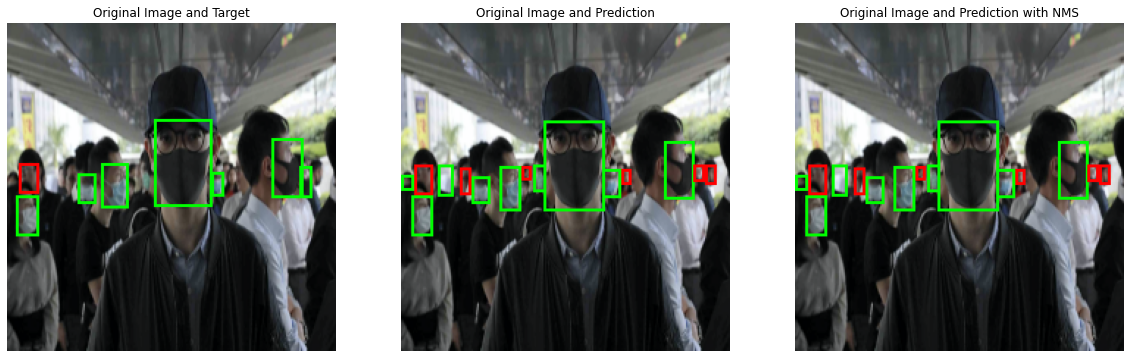

In [256]:
# Picking one image from the dataset
index = torch.randint(low=0, high=len(test_dataset), size=(1,)).item()
image, target = test_dataset[index]

# Evaluate the image
model_1.eval()
with torch.inference_mode():
    prediction = model_1([image.to(device)])[0]

# Applying Non Max Suppresion
nms_prediction = apply_nms(prediction, iou_threshold=0.02)

# Displaying the output
plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
plot_image(draw_bounding_box(image=image, target=target, transform=False))
plt.title('Original Image and Target');

plt.subplot(1, 3, 2)
plot_image(draw_bounding_box(image=image, target=prediction, transform=False))
plt.title('Original Image and Prediction');

plt.subplot(1, 3, 3)
plot_image(draw_bounding_box(image=image, target=nms_prediction, transform=False))
plt.title('Original Image and Prediction with NMS');

---

# Experiment No. 2

In this experiment - images, augmentation and optimizer.

## Understanding the Images

Reading all the images and ploting the shape

In [16]:
# Creating a list that contains image path, height and width of the image data.
img_meta=[]
for i in os.listdir(image_dir):
    path = Path(image_dir) / i
    shp = cv2.imread(str(path)).shape
    img_meta.append([path, shp[0], shp[1]])

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


In [18]:
# Creating a dataframe out of the img_meta list.
image_meta_df = pd.DataFrame(img_meta, columns=['img_path', 'height', 'width'])
# Adding a aspect ratio column
image_meta_df['ratio'] = round(image_meta_df['width'] / image_meta_df['height'], 2)
image_meta_df[:5]

img_path  height  width  ratio
0  data/face-mask-detection/images/maksssksksss31...     400    300   0.75
1  data/face-mask-detection/images/maksssksksss59...     400    301   0.75
2  data/face-mask-detection/images/maksssksksss65...     400    267   0.67
3  data/face-mask-detection/images/maksssksksss48...     217    400   1.84
4  data/face-mask-detection/images/maksssksksss17...     400    301   0.75

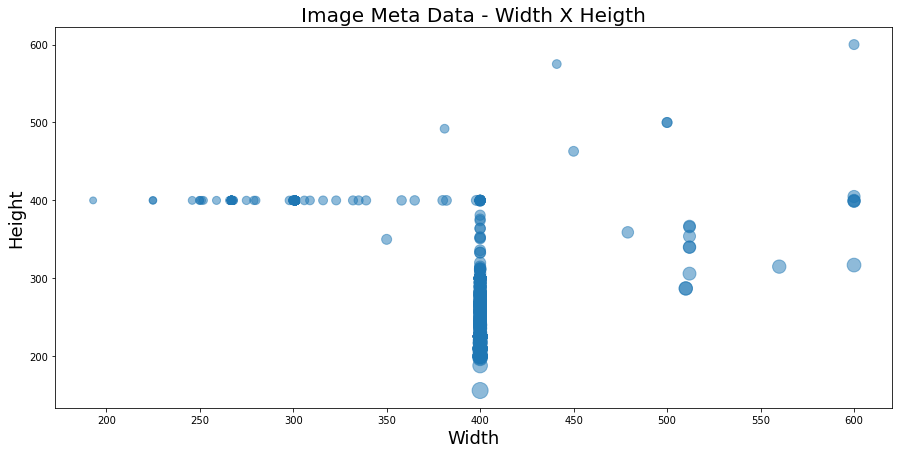

In [19]:
# Visualizing the dataframe as a scatter plot.
plt.figure(figsize=(15, 7))
plt.scatter(x=image_meta_df.width, y=image_meta_df.height, alpha=0.5, s=image_meta_df.ratio*100)
plt.xlabel('Width', {'fontsize': 18})
plt.ylabel('Height', {'fontsize': 18})
plt.title('Image Meta Data - Width X Heigth', {'fontsize': 20});

Images - 400 X 400

## Setting up Augmentation

In [17]:
# Creating augmentation for exp. 2
def get_transform_exp2(train: bool):
    """
    A function to create image augmentation using the Aulbumentations package.
    Args:
        train: A boolean input for justifying the augmentation on a training or validation dataset.
    return:
        A python dictionary containg 'image': In pytorch tensor format, 
                                     'bboxes': In pascal voc format.
                                     'labels': A int for class representation.
    """
    if train:
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.3),
            A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    else:
        return A.Compose([
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

## Preparing Dataset and Dataloaders

In [18]:
# Creating datasets for exp. 2 - we will be using the height and width of 400
train_dataset_exp2 = MaskDetection(image_dir=image_dir, 
                                   annot_dir=annot_dir, 
                                   width=400, 
                                   height=400, 
                                   transforms=get_transform_exp2(train=True))
test_dataset_exp2 = MaskDetection(image_dir=image_dir, 
                                  annot_dir=annot_dir, 
                                  width=400, 
                                  height=400, 
                                  transforms=get_transform_exp2(train=False))
print(f'[INFO] Length of the dataset: Train(with augmentation): {len(train_dataset_exp2)} and Test(with augmentation): {len(test_dataset_exp2)}')

[INFO] Length of the dataset: Train(with augmentation): 853 and Test(with augmentation): 853


In [19]:
# Processing the dataset into PyTorch dataset
test_split = 0.2
test_size = int(len(train_dataset_exp2) * test_split)
train_dataset_exp2 = torch.utils.data.Subset(dataset=train_dataset_exp2,
                                             indices=indices[:-test_size])
test_dataset_exp2 = torch.utils.data.Subset(dataset=test_dataset_exp2,
                                            indices=indices[-test_size:])
print(f'[INFO] Length of the dataset: Train(with augmentation): {len(train_dataset_exp2)} and Test(with augmentation): {len(test_dataset_exp2)}')

[INFO] Length of the dataset: Train(with augmentation): 683 and Test(with augmentation): 170


In [20]:
# Creating dataloaders similar to the first exp.
BATCH_SIZE = 10
NUM_WORKERS = os.cpu_count()

train_dataloader_exp2 = torch.utils.data.DataLoader(dataset=train_dataset_exp2,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    num_workers=NUM_WORKERS,
                                                    collate_fn=utils.collate_fn,
                                                    pin_memory=True)
test_dataloader_exp2 = torch.utils.data.DataLoader(dataset=test_dataset_exp2,
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=False,
                                                   num_workers=NUM_WORKERS,
                                                   collate_fn=utils.collate_fn,
                                                   pin_memory=True)
print(f'[INFO] Length of the dataloader: Train: {len(train_dataloader_exp2)} and Test: {len(test_dataloader_exp2)}')

[INFO] Length of the dataloader: Train: 69 and Test: 17


In [21]:
# Checking the first batch of the train dataloader
next(iter(train_dataloader_exp2))

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


[[tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
  
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
  
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]]),
  tensor([[[0.6392, 0.6392, 0.6392,  ..., 0.2118, 0.2039, 0.2000],
           [0.6379, 0.6379, 0.6392,  ..., 0.2131, 0.2026, 0.2000],
           [0.6356, 0.6356, 0.639

## Model Training

In [22]:
print(f'[INFO] System device: {device}')
NUM_CLASSES = 4

# Generating the model using the helper function
model_2 = get_fasterrcnn_resnet50_model(num_classes=NUM_CLASSES)
model_2.to(device)

[INFO] System device: cuda


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [23]:
# Creating a helper function to setup and run the model training.
def model_fit_exp2(epochs, max_lr, model, train_loader, val_loader, device, optm_func=torch.optim.Adam, weight_decay=0):
    """
    """
    # Releasing unoccupied cache memory
    torch.cuda.empty_cache()
    # Storing model parameters
    params = [p for p in model.parameters() if p.requires_grad]
    # Creating adam optimizer
    optimizer = optm_func(params=params,
                          lr=max_lr,
                          weight_decay=weight_decay)
    # Creating one cycle learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer,
                                                       max_lr=max_lr,
                                                       epochs=epochs,
                                                       steps_per_epoch=len(train_loader))
    # Starting the training loop
    for epoch in range(epochs):
        # Training for one epochs
        train_one_epoch(model=model,
                       optimizer=optimizer,
                       data_loader=train_loader,
                       device=device,
                       epoch=epoch,
                       print_freq=10)
        # Update the learning rate
        lr_scheduler.step()
        # Evaluate on the test dataset
        evaluate(model=model,
                data_loader=val_loader,
                device=device)

In [24]:
# Initiating the model training
model_fit_exp2(epochs=10,
               max_lr=1e-3,
               model=model_2,
               train_loader=train_dataloader_exp2,
               val_loader=test_dataloader_exp2,
               device=device,
               optm_func=torch.optim.Adam,
               weight_decay=1e-4)

Epoch: [0]  [ 0/69]  eta: 0:05:20  lr: 0.000001  loss: 1.7702 (1.7702)  loss_classifier: 1.4687 (1.4687)  loss_box_reg: 0.1048 (0.1048)  loss_objectness: 0.1767 (0.1767)  loss_rpn_box_reg: 0.0201 (0.0201)  time: 4.6433  data: 0.6703  max mem: 11857
Epoch: [0]  [10/69]  eta: 0:01:18  lr: 0.000007  loss: 1.8731 (1.8905)  loss_classifier: 1.3952 (1.3692)  loss_box_reg: 0.1074 (0.1222)  loss_objectness: 0.2791 (0.3418)  loss_rpn_box_reg: 0.0325 (0.0574)  time: 1.3307  data: 0.0613  max mem: 12306
Epoch: [0]  [20/69]  eta: 0:00:57  lr: 0.000012  loss: 1.6249 (1.6143)  loss_classifier: 1.1136 (1.1111)  loss_box_reg: 0.1207 (0.1254)  loss_objectness: 0.2847 (0.3276)  loss_rpn_box_reg: 0.0408 (0.0502)  time: 1.0012  data: 0.0003  max mem: 12306
Epoch: [0]  [30/69]  eta: 0:00:43  lr: 0.000018  loss: 0.9558 (1.3799)  loss_classifier: 0.4845 (0.8817)  loss_box_reg: 0.1485 (0.1566)  loss_objectness: 0.1926 (0.2905)  loss_rpn_box_reg: 0.0406 (0.0510)  time: 1.0087  data: 0.0002  max mem: 12306


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


Epoch: [0]  [40/69]  eta: 0:00:31  lr: 0.000024  loss: 0.7718 (1.2234)  loss_classifier: 0.3359 (0.7356)  loss_box_reg: 0.2186 (0.1736)  loss_objectness: 0.1418 (0.2689)  loss_rpn_box_reg: 0.0268 (0.0453)  time: 1.0169  data: 0.0002  max mem: 12306
Epoch: [0]  [50/69]  eta: 0:00:20  lr: 0.000030  loss: 0.6843 (1.1194)  loss_classifier: 0.2820 (0.6457)  loss_box_reg: 0.2368 (0.1850)  loss_objectness: 0.1273 (0.2463)  loss_rpn_box_reg: 0.0244 (0.0424)  time: 1.0220  data: 0.0002  max mem: 12306
Epoch: [0]  [60/69]  eta: 0:00:09  lr: 0.000036  loss: 0.6720 (1.0543)  loss_classifier: 0.2744 (0.5848)  loss_box_reg: 0.2656 (0.2049)  loss_objectness: 0.1212 (0.2244)  loss_rpn_box_reg: 0.0252 (0.0403)  time: 1.0261  data: 0.0002  max mem: 12306
Epoch: [0]  [68/69]  eta: 0:00:01  lr: 0.000040  loss: 0.6146 (0.9953)  loss_classifier: 0.2302 (0.5406)  loss_box_reg: 0.2475 (0.2076)  loss_objectness: 0.0983 (0.2090)  loss_rpn_box_reg: 0.0247 (0.0382)  time: 0.9931  data: 0.0002  max mem: 12306
Epoc

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


creating index...
index created!
Test:  [ 0/17]  eta: 0:00:22  model_time: 0.4478 (0.4478)  evaluator_time: 0.0367 (0.0367)  time: 1.3314  data: 0.8455  max mem: 12306
Test:  [16/17]  eta: 0:00:00  model_time: 0.4337 (0.4347)  evaluator_time: 0.0452 (0.0495)  time: 0.5353  data: 0.0499  max mem: 12306
Test: Total time: 0:00:09 (0.5421 s / it)
Averaged stats: model_time: 0.4337 (0.4347)  evaluator_time: 0.0452 (0.0495)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.119
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.145
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.138
 Average Recall     (AR) @[ Io

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


Epoch: [1]  [40/69]  eta: 0:00:30  lr: 0.000040  loss: 0.4110 (0.5245)  loss_classifier: 0.1471 (0.1749)  loss_box_reg: 0.1743 (0.2106)  loss_objectness: 0.0623 (0.1141)  loss_rpn_box_reg: 0.0157 (0.0249)  time: 1.0248  data: 0.0002  max mem: 12306
Epoch: [1]  [50/69]  eta: 0:00:19  lr: 0.000040  loss: 0.4088 (0.5027)  loss_classifier: 0.1310 (0.1664)  loss_box_reg: 0.1743 (0.2034)  loss_objectness: 0.0823 (0.1087)  loss_rpn_box_reg: 0.0171 (0.0241)  time: 1.0263  data: 0.0002  max mem: 12306
Epoch: [1]  [60/69]  eta: 0:00:09  lr: 0.000040  loss: 0.3977 (0.4873)  loss_classifier: 0.1245 (0.1615)  loss_box_reg: 0.1846 (0.2021)  loss_objectness: 0.0515 (0.1000)  loss_rpn_box_reg: 0.0154 (0.0237)  time: 1.0288  data: 0.0002  max mem: 12306
Epoch: [1]  [68/69]  eta: 0:00:01  lr: 0.000040  loss: 0.3821 (0.4769)  loss_classifier: 0.1264 (0.1584)  loss_box_reg: 0.1861 (0.2009)  loss_objectness: 0.0459 (0.0950)  loss_rpn_box_reg: 0.0129 (0.0226)  time: 0.9938  data: 0.0002  max mem: 12306
Epoc

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


creating index...
index created!
Test:  [ 0/17]  eta: 0:00:19  model_time: 0.4713 (0.4713)  evaluator_time: 0.0170 (0.0170)  time: 1.1523  data: 0.6623  max mem: 12306
Test:  [16/17]  eta: 0:00:00  model_time: 0.4363 (0.4388)  evaluator_time: 0.0175 (0.0190)  time: 0.4981  data: 0.0391  max mem: 12306
Test: Total time: 0:00:08 (0.5057 s / it)
Averaged stats: model_time: 0.4363 (0.4388)  evaluator_time: 0.0175 (0.0190)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.213
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.362
 Average Recall     (AR) @[ Io

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


Epoch: [2]  [ 0/69]  eta: 0:02:17  lr: 0.000040  loss: 0.2689 (0.2689)  loss_classifier: 0.0957 (0.0957)  loss_box_reg: 0.1355 (0.1355)  loss_objectness: 0.0332 (0.0332)  loss_rpn_box_reg: 0.0045 (0.0045)  time: 1.9912  data: 0.9695  max mem: 12306
Epoch: [2]  [10/69]  eta: 0:01:05  lr: 0.000040  loss: 0.3967 (0.4659)  loss_classifier: 0.1277 (0.1595)  loss_box_reg: 0.1651 (0.1842)  loss_objectness: 0.0804 (0.0976)  loss_rpn_box_reg: 0.0135 (0.0246)  time: 1.1127  data: 0.0883  max mem: 12306
Epoch: [2]  [20/69]  eta: 0:00:52  lr: 0.000040  loss: 0.3841 (0.4432)  loss_classifier: 0.1277 (0.1520)  loss_box_reg: 0.1913 (0.1877)  loss_objectness: 0.0483 (0.0820)  loss_rpn_box_reg: 0.0152 (0.0215)  time: 1.0252  data: 0.0002  max mem: 12306
Epoch: [2]  [30/69]  eta: 0:00:41  lr: 0.000040  loss: 0.3463 (0.4109)  loss_classifier: 0.1163 (0.1378)  loss_box_reg: 0.1558 (0.1768)  loss_objectness: 0.0495 (0.0744)  loss_rpn_box_reg: 0.0134 (0.0219)  time: 1.0253  data: 0.0002  max mem: 12306
Epoc

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


creating index...
index created!
Test:  [ 0/17]  eta: 0:00:22  model_time: 0.4533 (0.4533)  evaluator_time: 0.0110 (0.0110)  time: 1.3346  data: 0.8689  max mem: 12306
Test:  [16/17]  eta: 0:00:00  model_time: 0.4358 (0.4370)  evaluator_time: 0.0126 (0.0140)  time: 0.5035  data: 0.0512  max mem: 12306
Test: Total time: 0:00:08 (0.5123 s / it)
Averaged stats: model_time: 0.4358 (0.4370)  evaluator_time: 0.0126 (0.0140)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.580
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.290
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.342
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.437
 Average Recall     (AR) @[ Io

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


Epoch: [3]  [50/69]  eta: 0:00:19  lr: 0.000041  loss: 0.3728 (0.3838)  loss_classifier: 0.1274 (0.1240)  loss_box_reg: 0.1557 (0.1591)  loss_objectness: 0.0628 (0.0793)  loss_rpn_box_reg: 0.0131 (0.0215)  time: 1.0295  data: 0.0002  max mem: 12306
Epoch: [3]  [60/69]  eta: 0:00:09  lr: 0.000041  loss: 0.3500 (0.3805)  loss_classifier: 0.1161 (0.1243)  loss_box_reg: 0.1552 (0.1599)  loss_objectness: 0.0647 (0.0760)  loss_rpn_box_reg: 0.0131 (0.0203)  time: 1.0291  data: 0.0002  max mem: 12306
Epoch: [3]  [68/69]  eta: 0:00:01  lr: 0.000041  loss: 0.3555 (0.3812)  loss_classifier: 0.1158 (0.1255)  loss_box_reg: 0.1552 (0.1603)  loss_objectness: 0.0538 (0.0754)  loss_rpn_box_reg: 0.0147 (0.0200)  time: 0.9942  data: 0.0002  max mem: 12306
Epoch: [3] Total time: 0:01:11 (1.0325 s / it)


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


creating index...
index created!
Test:  [ 0/17]  eta: 0:00:20  model_time: 0.4575 (0.4575)  evaluator_time: 0.0118 (0.0118)  time: 1.2080  data: 0.7373  max mem: 12306
Test:  [16/17]  eta: 0:00:00  model_time: 0.4355 (0.4370)  evaluator_time: 0.0118 (0.0135)  time: 0.4952  data: 0.0435  max mem: 12306
Test: Total time: 0:00:08 (0.5037 s / it)
Averaged stats: model_time: 0.4355 (0.4370)  evaluator_time: 0.0118 (0.0135)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.404
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.700
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.409
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.356
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.439
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.590
 Average Recall     (AR) @[ Io

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


Epoch: [4]  [ 0/69]  eta: 0:02:08  lr: 0.000041  loss: 0.6256 (0.6256)  loss_classifier: 0.1965 (0.1965)  loss_box_reg: 0.1423 (0.1423)  loss_objectness: 0.2479 (0.2479)  loss_rpn_box_reg: 0.0389 (0.0389)  time: 1.8630  data: 0.7961  max mem: 12306
Epoch: [4]  [10/69]  eta: 0:01:04  lr: 0.000041  loss: 0.3441 (0.3767)  loss_classifier: 0.1173 (0.1236)  loss_box_reg: 0.1486 (0.1568)  loss_objectness: 0.0665 (0.0766)  loss_rpn_box_reg: 0.0155 (0.0197)  time: 1.0979  data: 0.0726  max mem: 12306
Epoch: [4]  [20/69]  eta: 0:00:52  lr: 0.000041  loss: 0.3441 (0.3594)  loss_classifier: 0.1202 (0.1245)  loss_box_reg: 0.1486 (0.1512)  loss_objectness: 0.0585 (0.0666)  loss_rpn_box_reg: 0.0140 (0.0171)  time: 1.0225  data: 0.0002  max mem: 12306
Epoch: [4]  [30/69]  eta: 0:00:40  lr: 0.000041  loss: 0.3355 (0.3547)  loss_classifier: 0.1165 (0.1211)  loss_box_reg: 0.1381 (0.1470)  loss_objectness: 0.0529 (0.0686)  loss_rpn_box_reg: 0.0116 (0.0179)  time: 1.0244  data: 0.0002  max mem: 12306
Epoc

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


creating index...
index created!
Test:  [ 0/17]  eta: 0:00:20  model_time: 0.4526 (0.4526)  evaluator_time: 0.0107 (0.0107)  time: 1.1870  data: 0.7224  max mem: 12306
Test:  [16/17]  eta: 0:00:00  model_time: 0.4359 (0.4370)  evaluator_time: 0.0107 (0.0125)  time: 0.4935  data: 0.0426  max mem: 12306
Test: Total time: 0:00:08 (0.5017 s / it)
Averaged stats: model_time: 0.4359 (0.4370)  evaluator_time: 0.0107 (0.0125)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.423
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.730
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.437
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.406
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.436
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.615
 Average Recall     (AR) @[ Io

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


Epoch: [5]  [40/69]  eta: 0:00:30  lr: 0.000041  loss: 0.3188 (0.3418)  loss_classifier: 0.1013 (0.1157)  loss_box_reg: 0.1479 (0.1496)  loss_objectness: 0.0460 (0.0604)  loss_rpn_box_reg: 0.0150 (0.0161)  time: 1.0247  data: 0.0003  max mem: 12306
Epoch: [5]  [50/69]  eta: 0:00:19  lr: 0.000041  loss: 0.3210 (0.3495)  loss_classifier: 0.1013 (0.1175)  loss_box_reg: 0.1479 (0.1513)  loss_objectness: 0.0499 (0.0644)  loss_rpn_box_reg: 0.0142 (0.0163)  time: 1.0273  data: 0.0002  max mem: 12306
Epoch: [5]  [60/69]  eta: 0:00:09  lr: 0.000041  loss: 0.3249 (0.3516)  loss_classifier: 0.1073 (0.1170)  loss_box_reg: 0.1313 (0.1485)  loss_objectness: 0.0553 (0.0694)  loss_rpn_box_reg: 0.0128 (0.0168)  time: 1.0274  data: 0.0002  max mem: 12306
Epoch: [5]  [68/69]  eta: 0:00:01  lr: 0.000041  loss: 0.3277 (0.3533)  loss_classifier: 0.1177 (0.1161)  loss_box_reg: 0.1217 (0.1455)  loss_objectness: 0.0643 (0.0739)  loss_rpn_box_reg: 0.0154 (0.0178)  time: 0.9927  data: 0.0002  max mem: 12306
Epoc

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


creating index...
index created!
Test:  [ 0/17]  eta: 0:00:20  model_time: 0.4625 (0.4625)  evaluator_time: 0.0125 (0.0125)  time: 1.1921  data: 0.7157  max mem: 12306
Test:  [16/17]  eta: 0:00:00  model_time: 0.4357 (0.4377)  evaluator_time: 0.0108 (0.0115)  time: 0.4925  data: 0.0422  max mem: 12306
Test: Total time: 0:00:08 (0.5006 s / it)
Averaged stats: model_time: 0.4357 (0.4377)  evaluator_time: 0.0108 (0.0115)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.800
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.494
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.456
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.641
 Average Recall     (AR) @[ Io

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


Epoch: [6]  [30/69]  eta: 0:00:41  lr: 0.000042  loss: 0.3499 (0.3524)  loss_classifier: 0.1016 (0.1159)  loss_box_reg: 0.1358 (0.1432)  loss_objectness: 0.0589 (0.0744)  loss_rpn_box_reg: 0.0165 (0.0189)  time: 1.0255  data: 0.0002  max mem: 12306
Epoch: [6]  [40/69]  eta: 0:00:30  lr: 0.000042  loss: 0.2810 (0.3380)  loss_classifier: 0.0940 (0.1125)  loss_box_reg: 0.1297 (0.1410)  loss_objectness: 0.0503 (0.0678)  loss_rpn_box_reg: 0.0094 (0.0167)  time: 1.0261  data: 0.0002  max mem: 12306
Epoch: [6]  [50/69]  eta: 0:00:19  lr: 0.000042  loss: 0.3147 (0.3480)  loss_classifier: 0.0994 (0.1141)  loss_box_reg: 0.1340 (0.1472)  loss_objectness: 0.0477 (0.0700)  loss_rpn_box_reg: 0.0095 (0.0166)  time: 1.0283  data: 0.0002  max mem: 12306
Epoch: [6]  [60/69]  eta: 0:00:09  lr: 0.000042  loss: 0.3595 (0.3491)  loss_classifier: 0.1215 (0.1141)  loss_box_reg: 0.1628 (0.1452)  loss_objectness: 0.0463 (0.0709)  loss_rpn_box_reg: 0.0131 (0.0188)  time: 1.0305  data: 0.0002  max mem: 12306
Epoc

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


creating index...
index created!
Test:  [ 0/17]  eta: 0:00:23  model_time: 0.4562 (0.4562)  evaluator_time: 0.0103 (0.0103)  time: 1.3708  data: 0.9024  max mem: 12306
Test:  [16/17]  eta: 0:00:00  model_time: 0.4368 (0.4376)  evaluator_time: 0.0116 (0.0131)  time: 0.5050  data: 0.0532  max mem: 12306
Test: Total time: 0:00:08 (0.5125 s / it)
Averaged stats: model_time: 0.4368 (0.4376)  evaluator_time: 0.0116 (0.0131)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.808
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.424
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.439
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.466
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.497
 Average Recall     (AR) @[ Io

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


Epoch: [7]  [10/69]  eta: 0:01:04  lr: 0.000043  loss: 0.3137 (0.3146)  loss_classifier: 0.1044 (0.1038)  loss_box_reg: 0.1576 (0.1529)  loss_objectness: 0.0278 (0.0436)  loss_rpn_box_reg: 0.0125 (0.0144)  time: 1.0916  data: 0.0664  max mem: 12306
Epoch: [7]  [20/69]  eta: 0:00:51  lr: 0.000043  loss: 0.3083 (0.3140)  loss_classifier: 0.1023 (0.1034)  loss_box_reg: 0.1500 (0.1441)  loss_objectness: 0.0331 (0.0507)  loss_rpn_box_reg: 0.0115 (0.0158)  time: 1.0219  data: 0.0003  max mem: 12306
Epoch: [7]  [30/69]  eta: 0:00:40  lr: 0.000043  loss: 0.3290 (0.3519)  loss_classifier: 0.1151 (0.1168)  loss_box_reg: 0.1620 (0.1545)  loss_objectness: 0.0499 (0.0629)  loss_rpn_box_reg: 0.0115 (0.0177)  time: 1.0250  data: 0.0003  max mem: 12306
Epoch: [7]  [40/69]  eta: 0:00:30  lr: 0.000043  loss: 0.3655 (0.3530)  loss_classifier: 0.1347 (0.1186)  loss_box_reg: 0.1620 (0.1544)  loss_objectness: 0.0508 (0.0631)  loss_rpn_box_reg: 0.0150 (0.0168)  time: 1.0281  data: 0.0003  max mem: 12306
Epoc

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


creating index...
index created!
Test:  [ 0/17]  eta: 0:00:23  model_time: 0.4492 (0.4492)  evaluator_time: 0.0092 (0.0092)  time: 1.3652  data: 0.9040  max mem: 12306
Test:  [16/17]  eta: 0:00:00  model_time: 0.4367 (0.4372)  evaluator_time: 0.0097 (0.0110)  time: 0.5027  data: 0.0533  max mem: 12306
Test: Total time: 0:00:08 (0.5096 s / it)
Averaged stats: model_time: 0.4367 (0.4372)  evaluator_time: 0.0097 (0.0110)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.494
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.803
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.556
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.458
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.544
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.651
 Average Recall     (AR) @[ Io

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


Epoch: [8]  [30/69]  eta: 0:00:41  lr: 0.000044  loss: 0.3117 (0.3396)  loss_classifier: 0.0997 (0.1076)  loss_box_reg: 0.1046 (0.1396)  loss_objectness: 0.0659 (0.0744)  loss_rpn_box_reg: 0.0145 (0.0179)  time: 1.0252  data: 0.0002  max mem: 12306
Epoch: [8]  [40/69]  eta: 0:00:30  lr: 0.000044  loss: 0.3124 (0.3356)  loss_classifier: 0.0996 (0.1057)  loss_box_reg: 0.1352 (0.1396)  loss_objectness: 0.0631 (0.0709)  loss_rpn_box_reg: 0.0142 (0.0194)  time: 1.0276  data: 0.0002  max mem: 12306
Epoch: [8]  [50/69]  eta: 0:00:19  lr: 0.000044  loss: 0.3486 (0.3380)  loss_classifier: 0.1020 (0.1084)  loss_box_reg: 0.1393 (0.1427)  loss_objectness: 0.0501 (0.0684)  loss_rpn_box_reg: 0.0163 (0.0186)  time: 1.0283  data: 0.0002  max mem: 12306
Epoch: [8]  [60/69]  eta: 0:00:09  lr: 0.000044  loss: 0.3069 (0.3384)  loss_classifier: 0.1149 (0.1090)  loss_box_reg: 0.1324 (0.1420)  loss_objectness: 0.0476 (0.0692)  loss_rpn_box_reg: 0.0105 (0.0181)  time: 1.0280  data: 0.0002  max mem: 12306
Epoc

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


creating index...
index created!
Test:  [ 0/17]  eta: 0:00:20  model_time: 0.4727 (0.4727)  evaluator_time: 0.0103 (0.0103)  time: 1.1869  data: 0.7025  max mem: 12306
Test:  [16/17]  eta: 0:00:00  model_time: 0.4363 (0.4380)  evaluator_time: 0.0102 (0.0112)  time: 0.4919  data: 0.0415  max mem: 12306
Test: Total time: 0:00:08 (0.4988 s / it)
Averaged stats: model_time: 0.4363 (0.4380)  evaluator_time: 0.0102 (0.0112)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.529
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.842
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.574
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.473
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.568
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.716
 Average Recall     (AR) @[ Io

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


Epoch: [9]  [10/69]  eta: 0:01:04  lr: 0.000045  loss: 0.2723 (0.2716)  loss_classifier: 0.0870 (0.0890)  loss_box_reg: 0.1094 (0.1162)  loss_objectness: 0.0380 (0.0535)  loss_rpn_box_reg: 0.0134 (0.0129)  time: 1.0886  data: 0.0644  max mem: 12306
Epoch: [9]  [20/69]  eta: 0:00:51  lr: 0.000045  loss: 0.2946 (0.3078)  loss_classifier: 0.0988 (0.1046)  loss_box_reg: 0.1244 (0.1328)  loss_objectness: 0.0467 (0.0568)  loss_rpn_box_reg: 0.0126 (0.0136)  time: 1.0220  data: 0.0002  max mem: 12306
Epoch: [9]  [30/69]  eta: 0:00:40  lr: 0.000045  loss: 0.3270 (0.3213)  loss_classifier: 0.1168 (0.1081)  loss_box_reg: 0.1436 (0.1354)  loss_objectness: 0.0563 (0.0622)  loss_rpn_box_reg: 0.0126 (0.0156)  time: 1.0257  data: 0.0002  max mem: 12306
Epoch: [9]  [40/69]  eta: 0:00:30  lr: 0.000045  loss: 0.3270 (0.3253)  loss_classifier: 0.0992 (0.1052)  loss_box_reg: 0.1328 (0.1365)  loss_objectness: 0.0595 (0.0643)  loss_rpn_box_reg: 0.0144 (0.0192)  time: 1.0281  data: 0.0002  max mem: 12306
Epoc

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


creating index...
index created!
Test:  [ 0/17]  eta: 0:00:23  model_time: 0.4479 (0.4479)  evaluator_time: 0.0093 (0.0093)  time: 1.3590  data: 0.9001  max mem: 12306
Test:  [16/17]  eta: 0:00:00  model_time: 0.4371 (0.4379)  evaluator_time: 0.0095 (0.0108)  time: 0.5029  data: 0.0530  max mem: 12306
Test: Total time: 0:00:08 (0.5101 s / it)
Averaged stats: model_time: 0.4371 (0.4379)  evaluator_time: 0.0095 (0.0108)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.538
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.866
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.617
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.526
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.566
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.663
 Average Recall     (AR) @[ Io

## Testing the model

In [53]:
def plot_model_testing(test_dataset, model, iou_threshold, transform):
    """
    """
    # Picking one image from the dataset
    index = torch.randint(low=0, high=len(test_dataset), size=(1,)).item()
    image, target = test_dataset[index]

    # Evaluate the image
    model.eval()
    with torch.inference_mode():
        prediction = model([image.to(device)])[0]
    
    # Applying Non Max Suppresion
    nms_prediction = apply_nms(prediction=prediction, iou_threshold=iou_threshold)
    
    # Displaying the output
    plt.figure(figsize=(20, 8))
    
    plt.subplot(1, 3, 1)
    plot_image(draw_bounding_box(image=image, target=target, transform=transform))
    plt.title('Original Image and Target');
    
    plt.subplot(1, 3, 2)
    plot_image(draw_bounding_box(image=image, target=prediction, transform=transform))
    plt.title('Original Image and Prediction');
    
    plt.subplot(1, 3, 3)
    plot_image(draw_bounding_box(image=image, target=nms_prediction, transform=transform))
    plt.title('Original Image and Prediction with NMS');

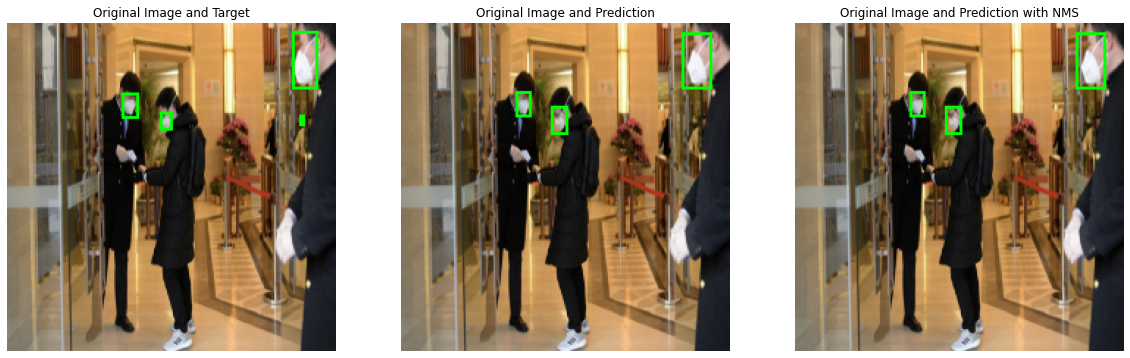

In [73]:
plot_model_testing(test_dataset=test_dataset,
                  model=model_2,
                  iou_threshold=0.3,
                  transform=False)